# Python Model Analysis
#### This notebook contains the output comparison procedures I used to tune the python3 version of the Burton-Johnson et. al. script. 

Directly porting the code from arcpy functions to a combination of rasterio and numpy functions with the exact thresholds used in the arcpy script does not produce the exact output as the published outcrop dataset [available here](https://www.the-cryosphere.net/10/1665/2016/).

I have several hypotheses for the cause.
    1. Rounding errors in the computations to generate the mask layers (particularly in the NDSI, NDWI, and B2/B10 masks)
    
    - This would lead to small omission and commission errors in the rock pixels
        
    2. Incorrect correction math in the image_correction.py script
    3. Rounding errors in the image_correction.py script
    4. Lost precsion while scaling pixel values to ints to save storage space in .tif files
    
### Test cases

To test these hypotheses I will generate several model outputs and create a diff raster using the OutputAnalysis class and compare errors from the various layers.

Ideal case is a perfect reproduction of the model output (obviously).

#### Case 1
Raw, uncoverted raster values as downloaded and extracted by the landsat-util/landsat/downloader.py script. These raster values will have to be scaled by .0001 for the reflectance bands and .01 for the temperature brightness bands. I don't think this will provide the best results, but there is the possibility that the images are already corrected before they are downoladed

#### Case 2
Correct the data using the utils/image_correction.py script and store the result as a raster with float values.

#### Case 3
Correct the data and store the resulting pixels as scaled integers.
Upon loading the pixels, scale them back to floats so that the thresholds do not change.
    
    

### Import all modules

In [1]:
import os

from utils.data_directory_manager import DataDirectoryManager
from utils.img_diff import OutputAnalysis
from utils.rasterize import rasterize_label, save_raster
from utils.raster_tools import get_window

import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np

### Configure directories and file paths

In [2]:
base_dir = "/home/dsa/DSA/images_manual"
dm = DataDirectoryManager(base_dir)

# The specifc scene upon which this testing will be done.
test_scene_id = "LC82201072015017LGN00"

# directory to hold the experimentally generated outputs
experiment_dir = os.path.join(dm.project_dir, "experimental")
if not os.path.exists(experiment_dir):
    os.mkdir(experiment_dir)

### Configure Groundtruth

We will be using a rasterized version of the polygon layer as our ground truth.

we need a layer that has pixel values over the full extent of the
test area. We're using one band from the full color image of our
segment for convenience. It would be better to just generate
a raster of 1's to ensure complete coverage to be burned by the
shapefile

In [3]:
# The shapefile downloaded from the paper supplement.
rock_shape = "/home/dsa/DSA/vectors/Landsat_8_Derived_Outcrop_Dataset_2016.shp"

rasterize_base = os.path.join(dm.corrected_image_dir, test_scene_id, test_scene_id + "full_color_seg.tif")
expected_path = os.path.join(dm.corrected_image_dir, "rasterized_rock_shape.tif")
assert os.path.exists(rasterize_base)

if os.path.exists(expected_path):
    with rio.open(expected_path) as expected_tif:
        meta = expected_tif.meta.copy()
        expected = expected_tif.read(1)
else:
    expected, meta = rasterize_label(rasterize_base, rock_shape)
    save_raster(expected[0], expected[1], expected_path)

### Configure test window

In [4]:
size = 512
col_offset = 12
row_offset = 10

### Case 1
- Load uncorrected raster from raw directory
- Scale reflectance bands (2, 3, 4, 5, 6) by .0001
- Scale brightness temperature band (10) by .01
- Run model with the following thresholds:
    - Mask1 layer1:
    - Mask1 layer2:
    - Mask1 layer3:
    - Mask1 layer5:
    - Mask2 layer1:
    - Mask2 layer2:
- Compare output
    
    

1183.9 2363.2


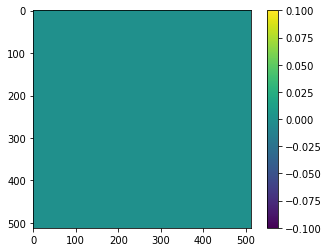

In [49]:
case1_path = os.path.join(experiment_dir, test_scene_id + "_case1.tif")
case1_diff_path = os.path.join(experiment_dir, test_scene_id + "case1_diff.tiff")
# If model output is already generated, load output from file
# otherwise, generate the output
if os.path.exists(case1_path):
    with rio.open(case1_path) as case1_file:
        case1 = case1_file.read(1)
    plt.imshow(case1)
else:
    pass
    # load uncorrected raster from raw directory
raw_path_base = os.path.join(dm.raw_image_dir, test_scene_id, test_scene_id + "_B")

refl_scale = .0001
brightness_scale = .1

mask1_step1_threshold = 400
mask1_step2_threshold = 0.075
mask1_step3_threshold = 0.045
mask1_step5_threshold = 2550
mask2_step1_threshold = 2500
mask2_step2_threshold = 0.45

b2, meta = get_window(raw_path_base + "2.TIF", col_off=col_offset, row_off=row_offset)
b3 = get_window(raw_path_base + "3.TIF", col_off=col_offset, row_off=row_offset)[0]
b4 = get_window(raw_path_base + "4.TIF", col_off=col_offset, row_off=row_offset)[0]
b5 = get_window(raw_path_base + "5.TIF", col_off=col_offset, row_off=row_offset)[0]
b6 = get_window(raw_path_base + "6.TIF", col_off=col_offset, row_off=row_offset)[0]
b10 = get_window(raw_path_base + "10.TIF", col_off=col_offset, row_off=row_offset)[0]
# scale values
b2 = b2 * refl_scale
b3 = b3 * refl_scale
b4 = b4 * refl_scale
b5 = b5 * refl_scale
b6 = b6 * refl_scale
b10 = b10 * brightness_scale

ndsi = (b3 - b6) / (b3 + b6)

ndwi = (b3 - b5) / (b3 + b5)

mask1_step1 = (b10 / b2 > mask1_step1_threshold).astype(int)
mask1_step2 = (ndsi < mask1_step2_threshold).astype(int)
mask1_step3 = (ndwi < mask1_step3_threshold).astype(int)
mask1_step5 = (b10 > mask1_step5_threshold).astype(int)

mask2_step1 = (b2 < mask2_step1_threshold).astype(int)
mask2_step2 = (ndwi < mask2_step2_threshold).astype(int)

mask1_sum = mask1_step1 + mask1_step2 + mask1_step3 + mask1_step5
mask1 = (mask1_sum == 4).astype(int)

mask2_sum = mask2_step1 + mask2_step2
mask2 = (mask2_sum == 2).astype(int)

final_sum = mask1 + mask2

case1 = (final_sum > 0).astype(int)

plt.imshow(mask1_step5.squeeze())
plt.colorbar()
print(np.amin(b10), np.amax(b10))

write_case1 = case1.transpose(2, 0, 1)
meta['dtype'] = rio.uint16
meta['count'] = 1
with rio.open(case1_path, 'w', **meta) as dst:
    dst.write(write_case1.astype(rio.uint16))

In [14]:
differ = OutputAnalysis(expected, case1)

In [15]:
print(differ)

IndexError: list index out of range